In [20]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

In [21]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [22]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_indep"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")

refresh_pickle = False

print(db)

/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_indep/linreg_indep.db


In [23]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [24]:
qp = dscQP(db, target, condition)
qp_df = qp.output_table
df    = stratify_dfcols_in_list(qp_df, 'fit', ['gradvi_direct', 'gradvi_compound', 'mr_ash', 'mr_ash_lasso_init'])
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
750,1,equicorrgauss,1,equicorrgauss/equicorrgauss_1,0.4,equicorrgauss/equicorrgauss_1,"(500,10000)",mr_ash,mr_ash/equicorrgauss_1_mr_ash_1
751,1,equicorrgauss,2,equicorrgauss/equicorrgauss_2,0.4,equicorrgauss/equicorrgauss_2,"(500,10000)",mr_ash,mr_ash/equicorrgauss_2_mr_ash_1
752,1,equicorrgauss,5,equicorrgauss/equicorrgauss_3,0.4,equicorrgauss/equicorrgauss_3,"(500,10000)",mr_ash,mr_ash/equicorrgauss_3_mr_ash_1
753,1,equicorrgauss,10,equicorrgauss/equicorrgauss_4,0.4,equicorrgauss/equicorrgauss_4,"(500,10000)",mr_ash,mr_ash/equicorrgauss_4_mr_ash_1
754,1,equicorrgauss,20,equicorrgauss/equicorrgauss_5,0.4,equicorrgauss/equicorrgauss_5,"(500,10000)",mr_ash,mr_ash/equicorrgauss_5_mr_ash_1
...,...,...,...,...,...,...,...,...,...
1345,10,equicorrgauss,1,equicorrgauss/equicorrgauss_146,0.8,equicorrgauss/equicorrgauss_146,"(500,10000)",gradvi_compound,gradvi_compound/equicorrgauss_146_gradvi_compo...
1346,10,equicorrgauss,2,equicorrgauss/equicorrgauss_147,0.8,equicorrgauss/equicorrgauss_147,"(500,10000)",gradvi_compound,gradvi_compound/equicorrgauss_147_gradvi_compo...
1347,10,equicorrgauss,5,equicorrgauss/equicorrgauss_148,0.8,equicorrgauss/equicorrgauss_148,"(500,10000)",gradvi_compound,gradvi_compound/equicorrgauss_148_gradvi_compo...
1348,10,equicorrgauss,10,equicorrgauss/equicorrgauss_149,0.8,equicorrgauss/equicorrgauss_149,"(500,10000)",gradvi_compound,gradvi_compound/equicorrgauss_149_gradvi_compo...


In [25]:
def read_elbo(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    
def get_elbo_from_df(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], **{x: [] for x in methods}}
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])
            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    resdict[method].append(read_elbo(dfs0, method))    
    return pd.DataFrame.from_dict(resdict)

def outlier_index(data):
    q3, q1 = np.percentile(data, [75, 25])
    iqr = q3 - q1
    xmin = q1 - 1.5 * iqr
    xmax = q3 + 1.5 * iqr
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def outlier_index_normal(data, factor = 0.9):
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    # In ANY normal distribution: IQR = Q3 - Q1 = 0.67448σ - (-0.67448σ) = 1.34896σ
    iqr_sigma = iqr / 1.34896
    median = np.median(data)
    xmin = median - factor * iqr_sigma
    xmax = median + factor * iqr_sigma
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

In [26]:
if refresh_pickle:
    elbodf = get_elbo_from_df(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [27]:
## remove sfix = 1
elbodf = stratify_dfcols_in_list(elbodf, "simulate.sfix", [2, 5, 10, 20])
elbodf

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound
10,2,0.4,1,1299.977391,1299.980555,1300.630805,1299.935555
11,2,0.4,2,1005.784112,1005.790998,1006.008180,1005.601981
12,2,0.4,3,942.273261,942.285867,943.429689,942.085386
13,2,0.4,4,1126.113127,1126.119218,1126.425362,1126.075822
14,2,0.4,5,701.045078,701.020200,701.433217,700.820736
...,...,...,...,...,...,...,...
145,20,0.8,6,1331.596486,1331.614866,1331.890739,1336.100991
146,20,0.8,7,1249.393145,1249.396646,1249.932314,1249.294660
147,20,0.8,8,1269.615761,1269.616631,1270.088813,1269.520970
148,20,0.8,9,1225.749075,1225.746813,1226.263155,1225.564939


In [28]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [29]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

Number of outliers removed : 5
Index 6,	PVE=0.4, s=2	 diff = -1.7081
Index 80,	PVE=0.8, s=2	 diff = -2.4599
Index 86,	PVE=0.8, s=2	 diff = 1.79794e+09
Index 87,	PVE=0.8, s=2	 diff = -2.13866
Index 93,	PVE=0.8, s=5	 diff = -2.76666


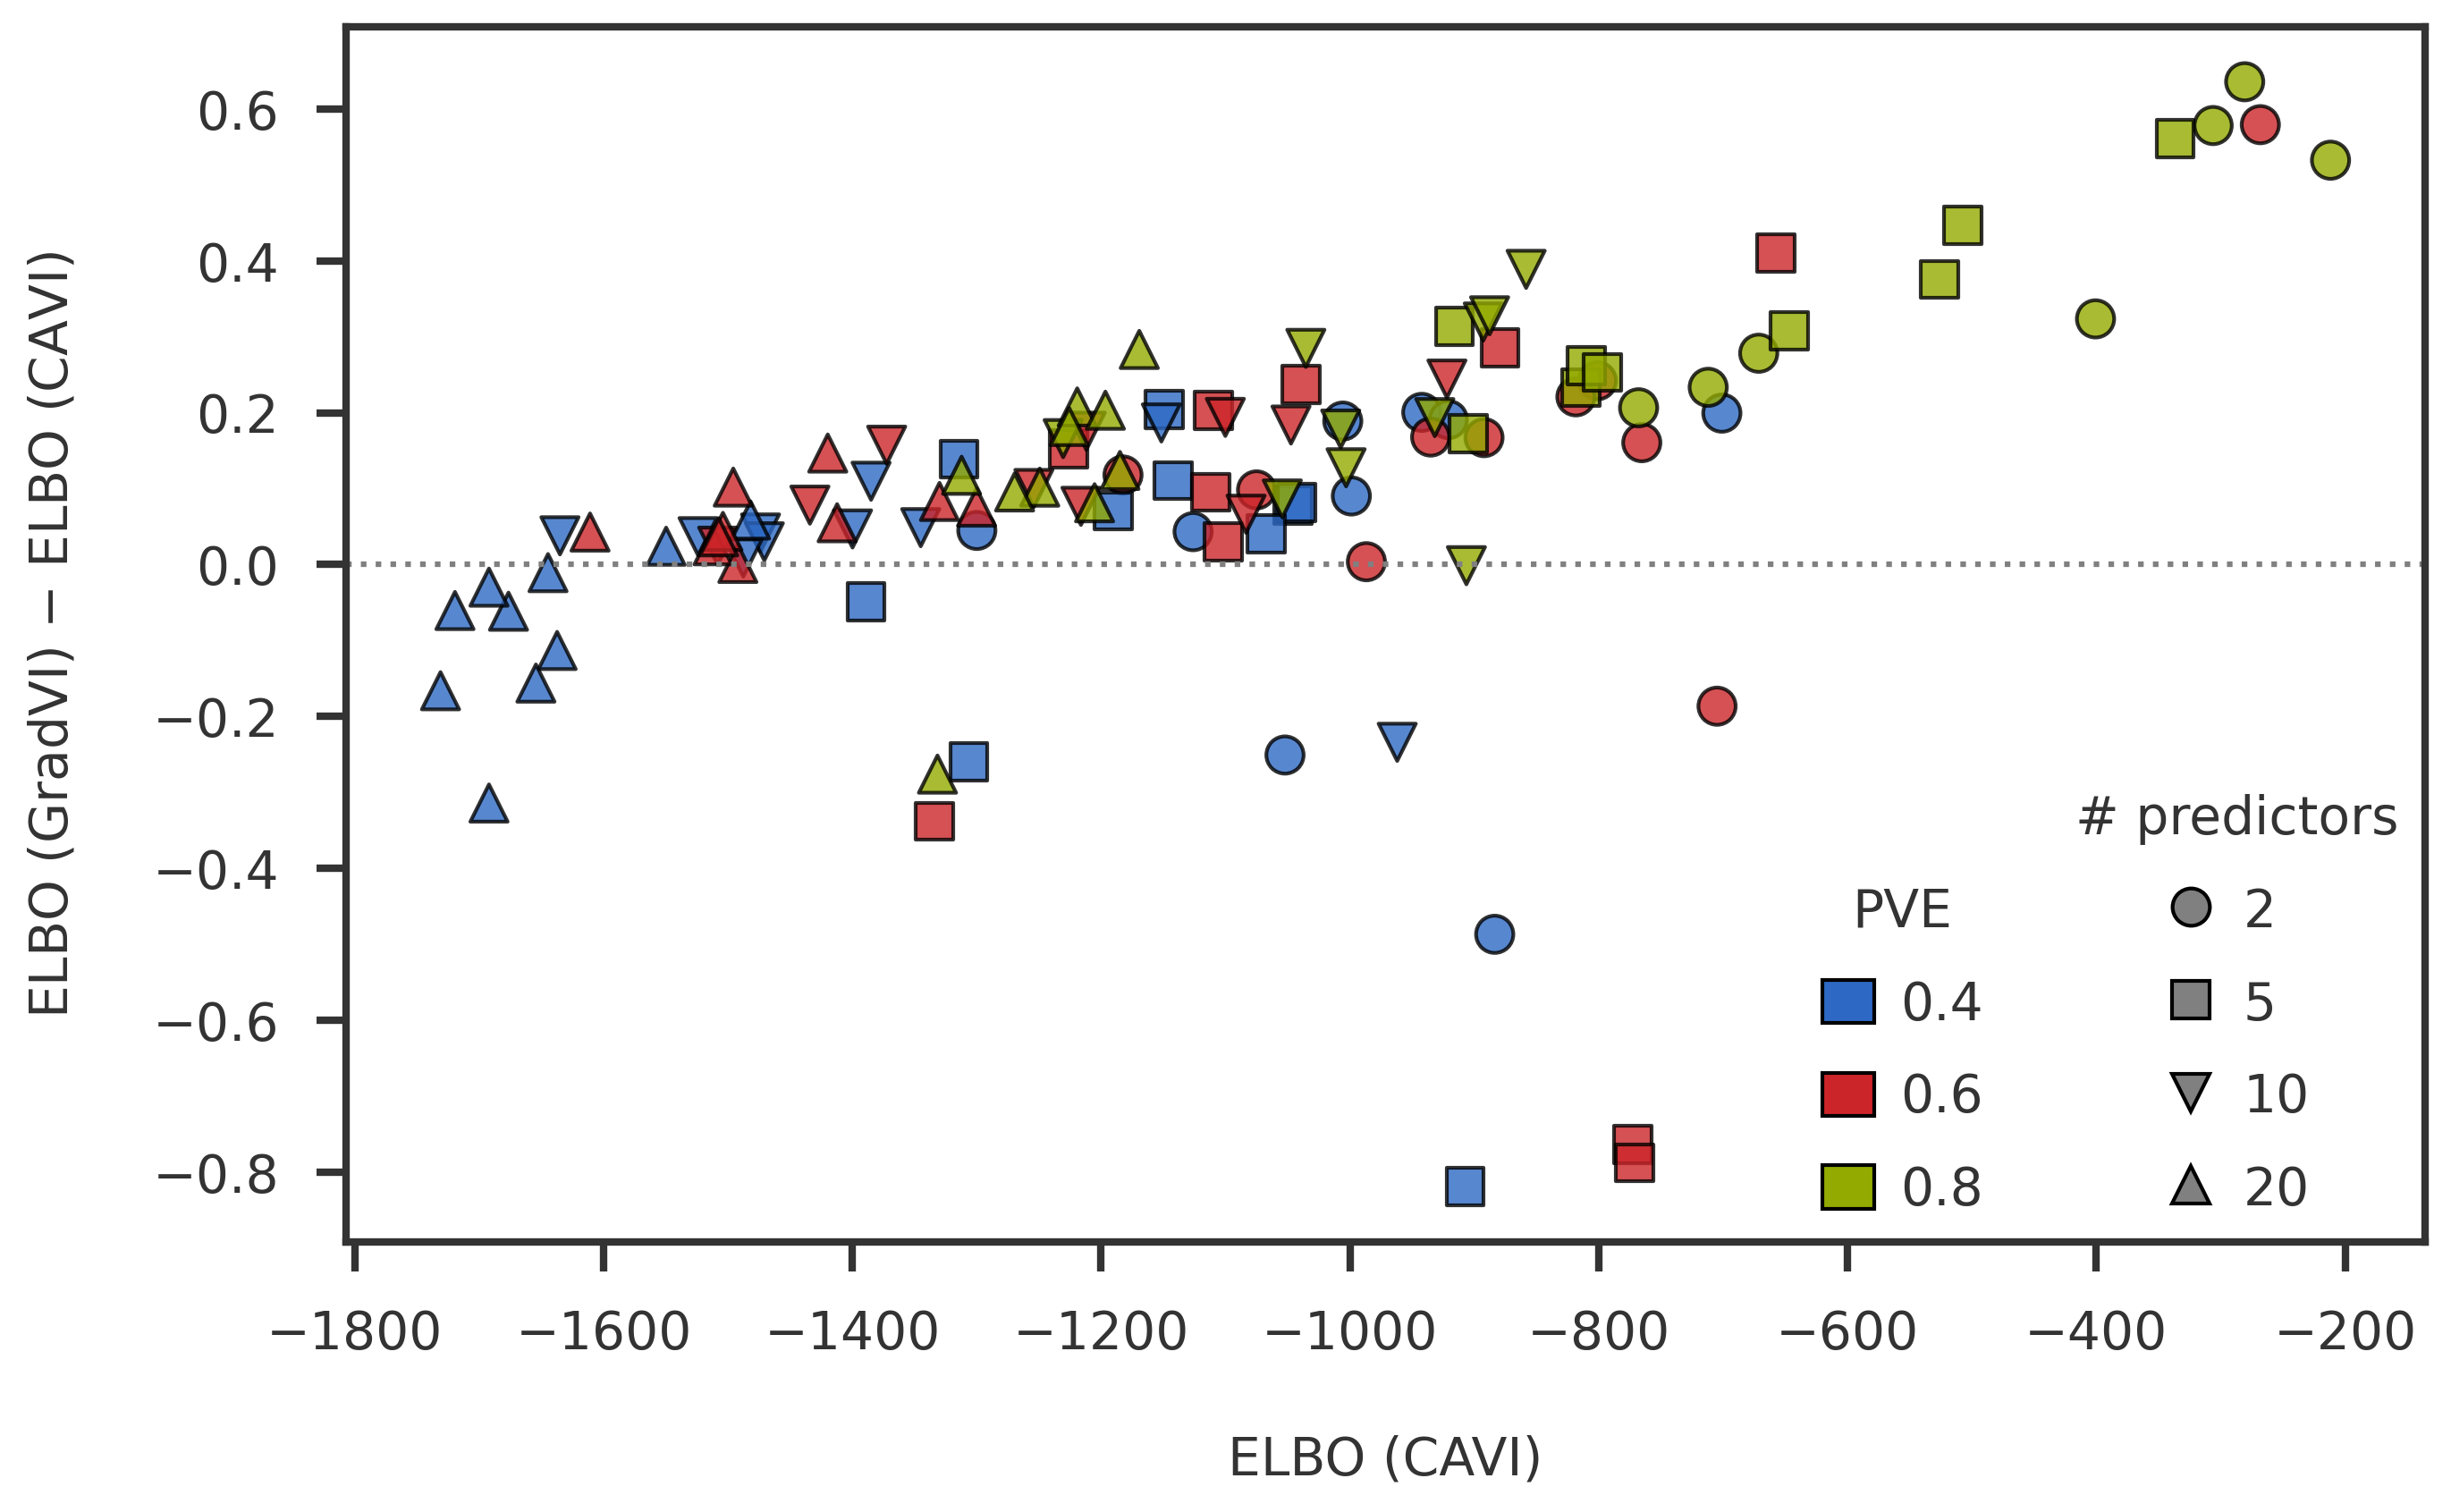

In [92]:
fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def plot_elbo_scatter(ax, df, reference, target, has_outliers = False, use_gradvi_alternate = False):
    ref   = - df[reference].to_numpy()
    tgt   = - df[target].to_numpy()
    if use_gradvi_alternate and target.startswith("gradvi"):
        alt_target = "gradvi_direct" if target == "gradvi_compound" else "gradvi_compound"
        tgt2 = - df[alt_target].to_numpy()
        tgt  = np.maximum(tgt, tgt2)
    diff  = tgt - ref
    
    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())
    
    if has_outliers:
        iremove = np.array([])
        ikeep   = np.arange(diff.shape[0])
    else:
        iremove, ikeep = outlier_index_normal(diff, factor = 10.0)
        print (f"Number of outliers removed : {iremove[0].shape[0]}")
        for i in iremove[0]:
            print(f"Index {i},\tPVE={pvevals[pveidx[i]]}, s={sfixvals[sfixidx[i]]}\t diff = {diff[i]:g}")
    mcolors  = mpl_stylesheet.banskt_colors()
    mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
    
    markers = [mmarkers[i] for i in sfixidx[ikeep]]
    
    for sidx, sfix in sfixvals.items():
        marker = mmarkers[sidx]
        #print (sidx, sfix, marker)
        _idx = np.where(sfixidx == sidx)[0]
        _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
        _colors = [mcolors[i] for i in pveidx[_ikeep]]
        ax.scatter(ref[_ikeep], diff[_ikeep], marker = marker, c = _colors,
                   alpha = 0.8, s = 100, edgecolors = 'black', label = f"{sfix}")
    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    
    # legend for number of causal predictors
    mhandles = list()
    mlabels  = list()
    for sidx, sfix in sfixvals.items():
        marker = mmarkers[sidx]
        handle = mlines.Line2D([], [], color='grey', mec='black', marker=marker, ls='', ms=10)
        mhandles.append(handle)
        mlabels.append(f"{sfix}")
    leg1 = plt.legend(handles = mhandles, labels = mlabels, title = r"# predictors",
                      loc = 'lower right', bbox_to_anchor = (1.0, 0.0))
    plt.gca().add_artist(leg1)
    
    # legend for PVE
    mhandles = list()
    mlabels  = list()
    for pidx, pve in pvevals.items():
        color = mcolors[pidx]
        handle = mpatches.Patch(facecolor = color, edgecolor = 'black')
        mhandles.append(handle)
        mlabels.append(f"{pve}")
    leg2 = ax.legend(handles = mhandles, labels = mlabels, title = r"PVE",
                     loc = 'lower right', bbox_to_anchor = (0.8, 0.0))
    
    return




plot_elbo_scatter(ax1, elbodf, "mr_ash_lasso_init", "gradvi_compound", 
                  has_outliers = False, use_gradvi_alternate = True)
ax1.set_xlabel("ELBO (CAVI)")
ax1.set_ylabel(r"ELBO (GradVI) $-$ ELBO (CAVI)")
plt.show()

In [15]:
elbodf

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound
10,2,0.4,1,1299.977391,1299.980555,1300.630805,1299.935555
11,2,0.4,2,1005.784112,1005.790998,1006.008180,1005.601981
12,2,0.4,3,942.273261,942.285867,943.429689,942.085386
13,2,0.4,4,1126.113127,1126.119218,1126.425362,1126.075822
14,2,0.4,5,701.045078,701.020200,701.433217,700.820736
...,...,...,...,...,...,...,...
145,20,0.8,6,1331.596486,1331.614866,1331.890739,1336.100991
146,20,0.8,7,1249.393145,1249.396646,1249.932314,1249.294660
147,20,0.8,8,1269.615761,1269.616631,1270.088813,1269.520970
148,20,0.8,9,1225.749075,1225.746813,1226.263155,1225.564939


In [54]:
ref   = - elbodf["mr_ash_lasso_init"].to_numpy()
tgt   = - elbodf["gradvi_compound"].to_numpy()
diff  = tgt - ref

In [55]:
np.argmax(diff)

86

In [67]:
iremove, ikeep = outlier_index_normal(diff, factor = 1000.0)
iremove

(array([44, 50, 56, 80, 86, 87, 93]),)

In [63]:
elbodf["gradvi_compound"].idxmin()

116

In [64]:
elbodf.loc[[116]]

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound
116,2,0.8,7,154.000699,154.005095,181.548207,-1.797937e+09


In [60]:
ref[86]

-154.0050946851953

In [61]:
tgt[86]

1797936607.591507

In [62]:
diff[86]

1797936761.5966017